In [1]:
# train_bow_rf.py

import re
import pickle
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk.corpus import stopwords

# Download stopwords once
nltk.download("stopwords", quiet=True)
stops = set(stopwords.words("indonesian") + stopwords.words("english"))

# Prepare stemmer
factory = StemmerFactory()
stemmer = nltk.stem.SnowballStemmer("english")

# Load & label hoax
hoax = (
    pd.read_csv("../Dataset/hoax_news.csv", usecols=["Title", "Narasi", "category"])
      .dropna(subset=["Title", "Narasi", "category"])
)
hoax = hoax[~hoax["category"].isin(["Benar", "Disinformasi"])].copy()
hoax.rename(columns={"Title": "title", "Narasi": "body"}, inplace=True)
hoax["label"] = "hoax"

# Load & label real
real = (
    pd.read_csv("../Dataset/detik_news.csv", usecols=["page", "title", "url", "content"])
      .dropna(subset=["title", "content"])
)
real.rename(columns={"content": "body"}, inplace=True)
real["label"] = "real"
real = real[["title", "body", "label"]]

# Outlier removal on hoax lengths
for col in ("title", "body"):
    lengths = hoax[col].str.len()
    q1, q3 = lengths.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    hoax = hoax[(lengths >= lo) & (lengths <= hi)]

hoax.drop(columns=["category"], inplace=True)

# Balance classes
df = pd.concat([hoax, real], ignore_index=True)
n = df["label"].value_counts().min()
df = df.groupby("label", group_keys=False).apply(lambda g: g.sample(n, random_state=42))

# Train/val/test split 70:20:10
X = df[["title", "body"]].astype(str)
y = df["label"]

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)
val_frac = 0.2 / 0.9
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_frac, stratify=y_temp, random_state=42
)

# Clean, tokenize, stem
def clean_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [t for t in text.split() if t not in stops and len(t) > 1]
    return [stemmer.stem(t) for t in tokens]

for split in (X_train, X_val, X_test):
    split["text"] = (
        split["title"].apply(clean_tokenize).apply(" ".join)
        + " "
        + split["body"].apply(clean_tokenize).apply(" ".join)
    )

# BOW
vectorizer = CountVectorizer(max_features=1000)
X_train_bow = vectorizer.fit_transform(X_train["text"])
X_val_bow   = vectorizer.transform(X_val["text"])
X_test_bow  = vectorizer.transform(X_test["text"])

# Mask augmentation (40%)
mask_prob = 0.40
rng = np.random.default_rng(42)
arr = X_train_bow.toarray()
mask = rng.binomial(1, 1 - mask_prob, size=arr.shape)
aug = arr * mask

X_train_final = np.vstack([arr, aug])
y_train_final = np.hstack([y_train.values, y_train.values])

# Train Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train_final, y_train_final)

# Save pipeline
with open("rf_bow_aug_hoax.pkl", "wb") as f:
    pickle.dump({
        "model":       rf,
        "vectorizer":  vectorizer,
        "stopwords":   stops,
        "mask_prob":   mask_prob,
        "stemmer":     stemmer
    }, f)

print("Saved BOW+RandomForest pipeline to rf_bow_aug_hoax.pkl")

Saved BOW+RandomForest pipeline to rf_bow_aug_hoax.pkl


=== Synthetic OOD Results (Random Forest) ===
Accuracy: 0.5333333333333333
              precision    recall  f1-score   support

        hoax      0.534     0.988     0.693        80
        real      0.500     0.014     0.028        70

    accuracy                          0.533       150
   macro avg      0.517     0.501     0.360       150
weighted avg      0.518     0.533     0.383       150



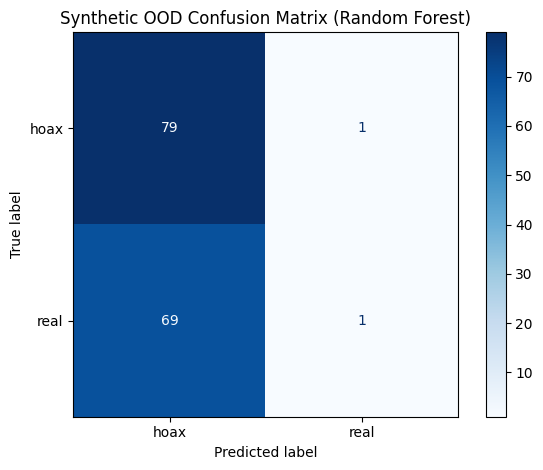

In [2]:
# test_bow_rf_synthetic.py

import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay
)

# 1. Load the RandomForest pipeline
with open("rf_bow_aug_hoax.pkl", "rb") as f:
    data         = pickle.load(f)
    rf_model     = data["model"]
    vectorizer   = data["vectorizer"]
    stops        = data["stopwords"]

# 2. Same cleaning & tokenizing
def clean_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    return [t for t in text.split() if t not in stops and len(t) > 1]

# 3. Load synthetic (OOD) test set
titles, bodies, true_labels = [], [], []
with open("../Dataset/synthetic_news.txt", "r", encoding="utf-8") as f:
    for line in f:
        t, b, lab = line.strip().split("\t")
        titles.append(t)
        bodies.append(b)
        true_labels.append(lab)

# 4. Build feature texts by concatenating cleaned title + body
texts = [
    " ".join(clean_tokenize(t) + clean_tokenize(b))
    for t, b in zip(titles, bodies)
]

# 5. Vectorize and convert to array
X_syn = vectorizer.transform(texts).toarray()

# 6. Predict & evaluate
preds = rf_model.predict(X_syn)
print("=== Synthetic OOD Results (Random Forest) ===")
print("Accuracy:", accuracy_score(true_labels, preds))
print(classification_report(true_labels, preds, digits=3))

# 7. Confusion matrix display
cm = confusion_matrix(true_labels, preds, labels=["hoax", "real"])
disp = ConfusionMatrixDisplay(cm, display_labels=["hoax", "real"])
disp.plot(cmap="Blues")
plt.title("Synthetic OOD Confusion Matrix (Random Forest)")
plt.tight_layout()
plt.show()
